In [100]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt

## 1. Store "Income by Country" xlsx into DataFrame

In [101]:
income_path = '../Resources/Income by Country.xlsx'
income_xls = pd.ExcelFile(income_path)
income_15_18 = pd.read_excel(income_xls,'GNI per capita')

### Select columns

In [102]:
income_15_18 = income_15_18[['Country',2015,2016,2017,2018]]
income_15_18.head()

,Country,2015,2016,2017,2018
0,Afghanistan,1783,1766,1767,1746
1,Albania,11098,11534,11831,12300
2,Algeria,13330,13832,13656,13639
3,Andorra,45260,46553,47550,48641
4,Angola,6440,6051,5950,5555


### Convert between rows and columns

In [103]:
income_15_18 = income_15_18.melt(id_vars=["Country"], 
        var_name="Year", 
        value_name="GNI_per_capita")
income_15_18.head()

,Country,Year,GNI_per_capita
0,Afghanistan,2015,1783
1,Albania,2015,11098
2,Algeria,2015,13330
3,Andorra,2015,45260
4,Angola,2015,6440


### Sort rows by country and year

In [105]:
income_15_18 = income_15_18.sort_values(['Country','Year'],ascending=True).reset_index(drop=True)
income_15_18 = income_15_18.rename(columns={'Country':'country','Year':'year','GNI_per_capita':'gni_per_capita'})
income_15_18.head()

,country,year,gni_per_capita
0,Afghanistan,2015,1783
1,Afghanistan,2016,1766
2,Afghanistan,2017,1767
3,Afghanistan,2018,1746
4,Albania,2015,11098


## 2. Use a loop tp store "Happiness" csv into DataFrame and select columns that we want

In [106]:
years = [2015,2016,2017,2018]
def df(year):
    happiness_path = f'../Resources/{year}.csv'
    happiness_df = pd.read_csv(happiness_path)
    happiness_df['Year'] = year
    happiness_df = happiness_df[['Country','Year','Happiness Score']]
    happiness_df = happiness_df.rename(columns={'Country':'country','Year':'year','Happiness Score':'happiness_score'})
    return happiness_df

happiness_years = [df(year) for year in years]

### Append happiness dataframes from 2015-2018 together

In [107]:
happiness_15_18 = happiness_years[0].append([happiness_years[1],happiness_years[2],happiness_years[3]])

### Sort rows by country and year

In [108]:
happiness_15_18 = happiness_15_18.sort_values(['country','year'],ascending=True).reset_index(drop=True)
happiness_15_18.head()

,country,year,happiness_score
0,Afghanistan,2015,3.575
1,Afghanistan,2016,3.360
2,Afghanistan,2017,3.794
3,Afghanistan,2018,3.632
4,Albania,2015,4.959


## 3. Combine the income and happiness dataframe together depending on the country and year

In [109]:
combined_df = income_15_18.merge(happiness_15_18,on=['country','year'])
combined_df.head(8)

,country,year,gni_per_capita,happiness_score
0,Afghanistan,2015,1783,3.575
1,Afghanistan,2016,1766,3.360
2,Afghanistan,2017,1767,3.794
3,Afghanistan,2018,1746,3.632
4,Albania,2015,11098,4.959
5,Albania,2016,11534,4.655
6,Albania,2017,11831,4.644
7,Albania,2018,12300,4.586


Split and extract data as a seperate dataframe in each year 

In [110]:
combined_2015 = combined_df.loc[combined_df['year']==2015]
combined_2016 = combined_df.loc[combined_df['year']==2016]
combined_2017 = combined_df.loc[combined_df['year']==2017]
combined_2018 = combined_df.loc[combined_df['year']==2018]
combined_2018

,country,year,gni_per_capita,happiness_score
3,Afghanistan,2018,1746,3.632
7,Albania,2018,12300,4.586
11,Algeria,2018,13639,5.295
15,Angola,2018,5555,3.795
19,Argentina,2018,17611,6.388
...,...,...,...,...
522,Uruguay,2018,19435,6.379
526,Uzbekistan,2018,6462,6.096
530,Yemen,2018,1433,3.355
534,Zambia,2018,3582,4.377


### Connect to local database

In [111]:
rds_connection_string = "postgres:shenshuishui325@localhost:5432/ETL"
engine = create_engine(f'postgresql://{rds_connection_string}')

In [112]:
engine.table_names()

['combined_2015', 'combined_2016', 'combined_2017', 'combined_2018']

In [113]:
combined_2015.to_sql(name='combined_2015', con=engine, if_exists='append', index=False)
combined_2016.to_sql(name='combined_2016', con=engine, if_exists='append', index=False)
combined_2017.to_sql(name='combined_2017', con=engine, if_exists='append', index=False)
combined_2018.to_sql(name='combined_2018', con=engine, if_exists='append', index=False)

In [114]:
pd.read_sql_query('select * from combined_2015', con=engine).head()

,country,year,gni_per_capita,happiness_score
0,Afghanistan,2015,1783,3.575
1,Albania,2015,11098,4.959
2,Algeria,2015,13330,5.605
3,Angola,2015,6440,4.033
4,Argentina,2015,18901,6.574


In [117]:
pd.read_sql_query('select * from combined_2016', con=engine).head()

,country,year,gni_per_capita,happiness_score
0,Afghanistan,2016,1766,3.360
1,Albania,2016,11534,4.655
2,Algeria,2016,13832,6.355
3,Angola,2016,6051,3.866
4,Argentina,2016,18249,6.650


In [115]:
pd.read_sql_query('select * from combined_2016', con=engine).head()

,country,year,gni_per_capita,happiness_score
0,Afghanistan,2016,1766,3.360
1,Albania,2016,11534,4.655
2,Algeria,2016,13832,6.355
3,Angola,2016,6051,3.866
4,Argentina,2016,18249,6.650


 Define a loop to configure the income vs. country plot 2015-2018

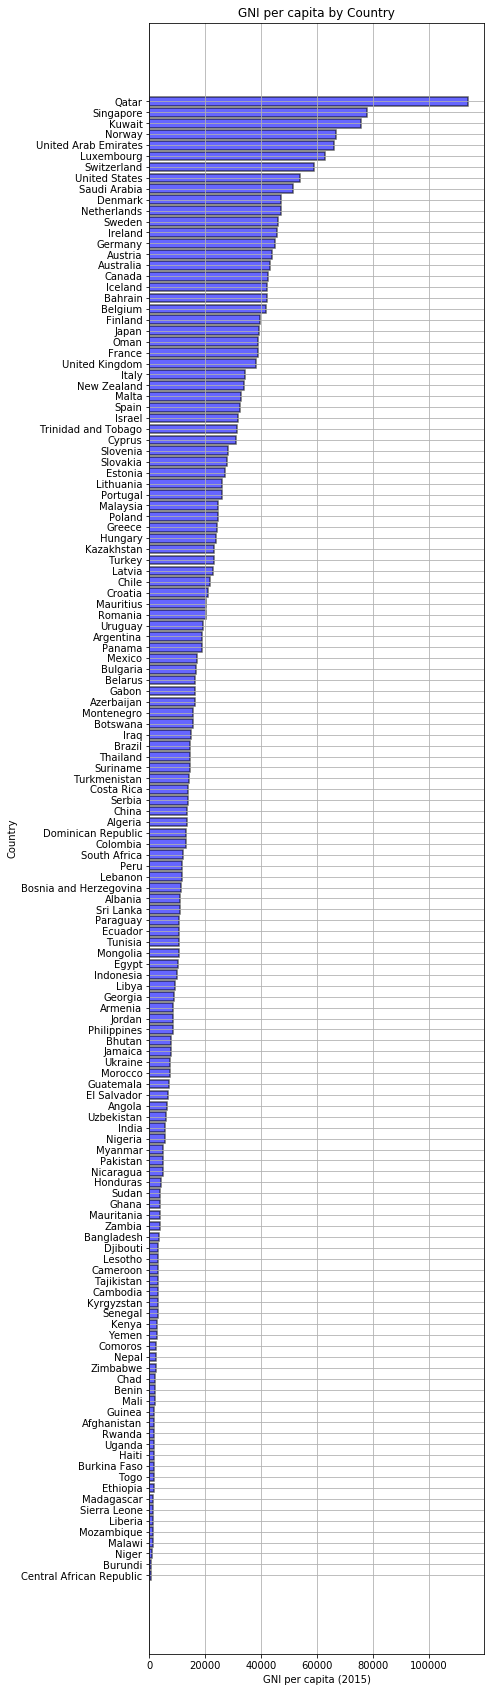

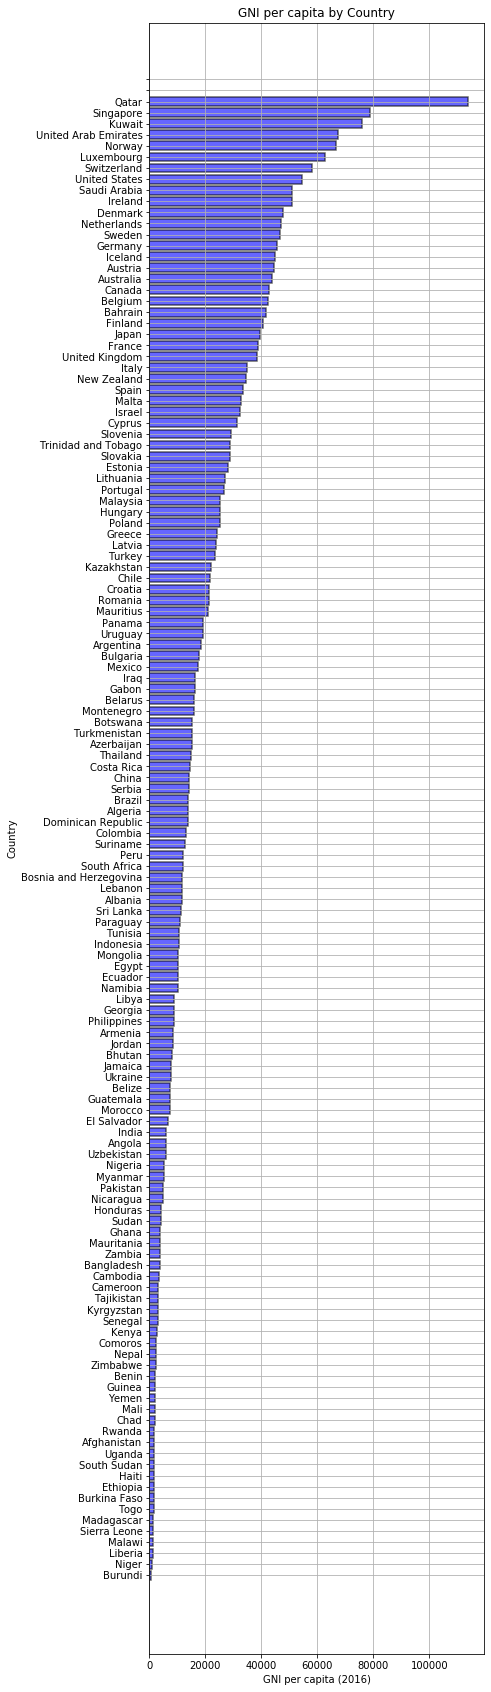

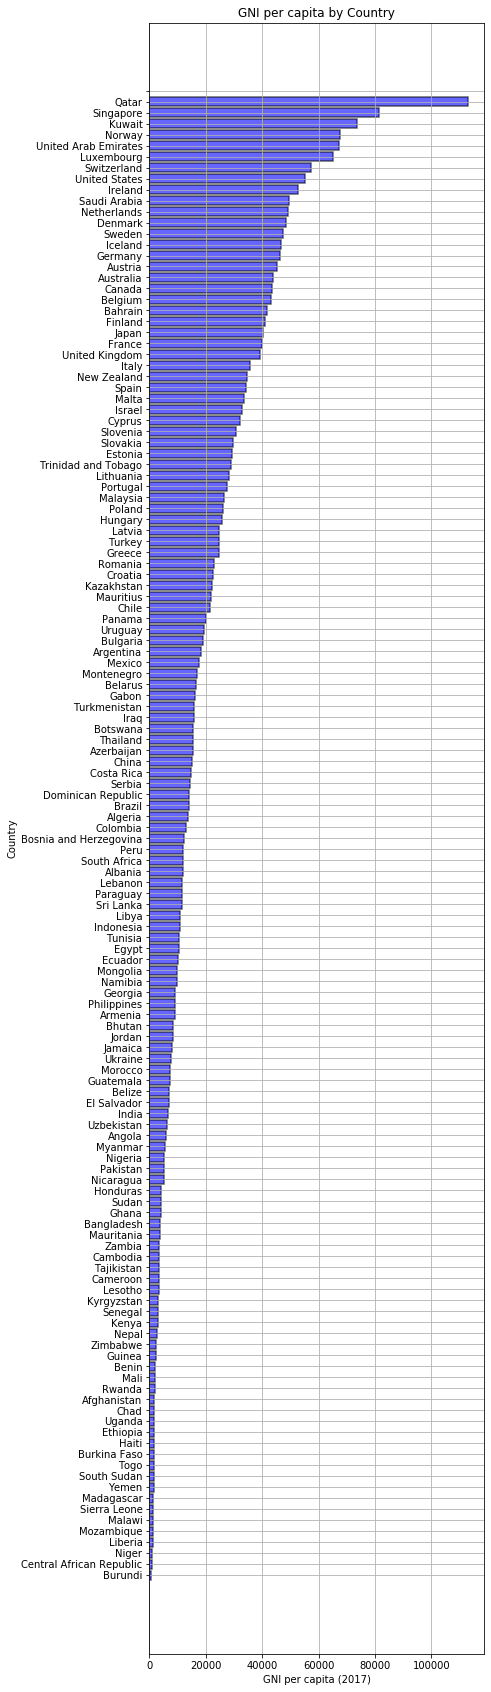

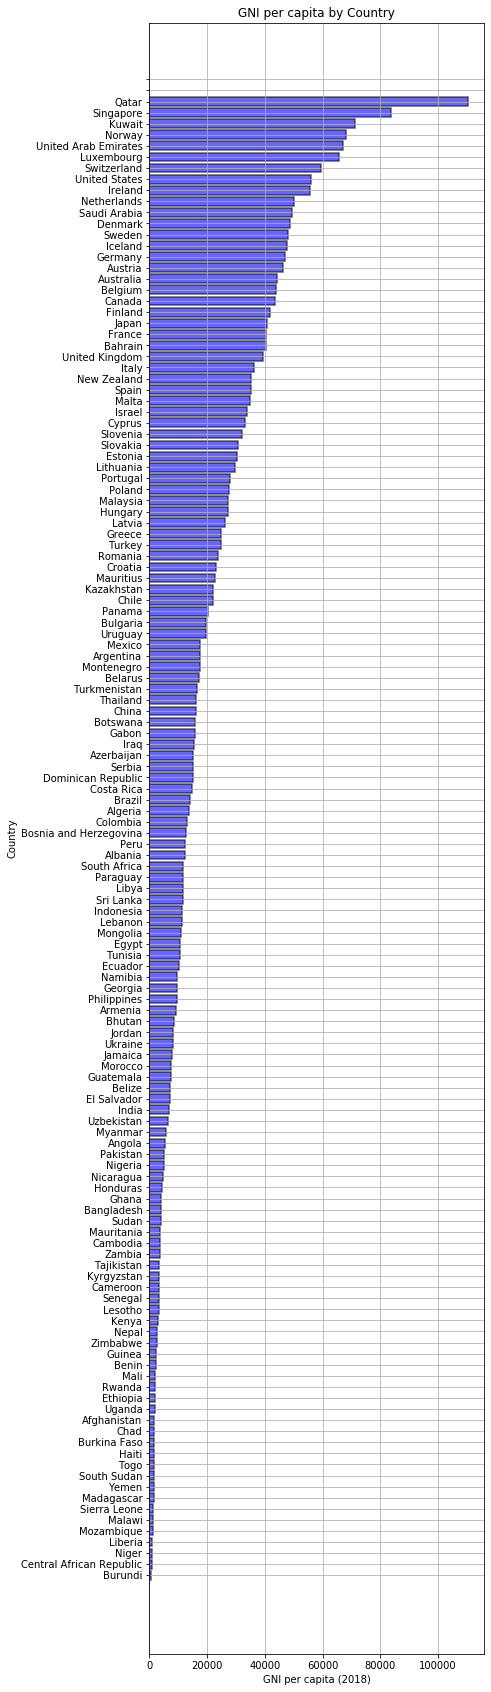

In [116]:
years = [2015,2016,2017,2018]
for year in years:
    income_year_df = combined_df.loc[(combined_df['year']==year)][['country','gni_per_capita']]
    income_year_df = income_year_df.sort_values('gni_per_capita',ascending=False).reset_index(drop=True)
    x_axis = list(range(0,136,1))
    tick_locations = x_axis
    y_ticks = income_year_df["country"][::-1]
    x_values = income_year_df["gni_per_capita"][::-1]
    fig, ax = plt.subplots(figsize=(6,30))
    ax.barh(y_ticks, x_values, color="b", alpha=0.6, linewidth=1.5, edgecolor='black')
    ax.set_yticks(x_axis)
    ax.set_xlabel(f"GNI per capita ({year})")
    ax.set_ylabel("Country")
    ax.set_title("GNI per capita by Country")
    ax.grid()

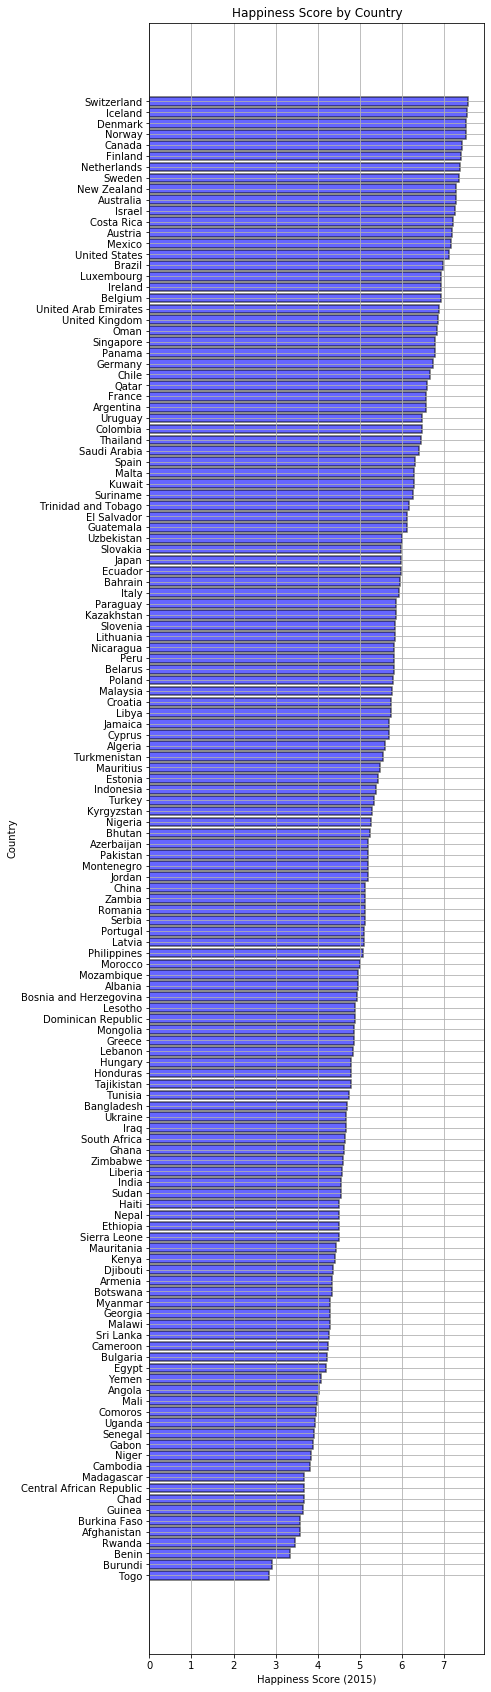

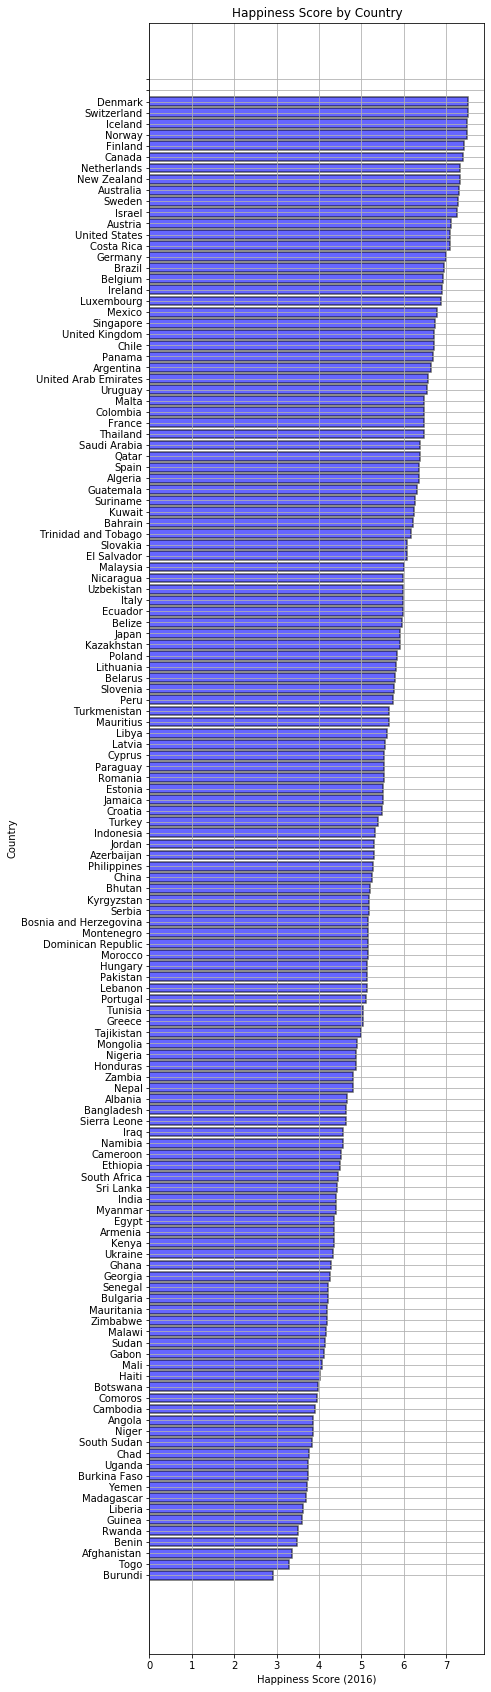

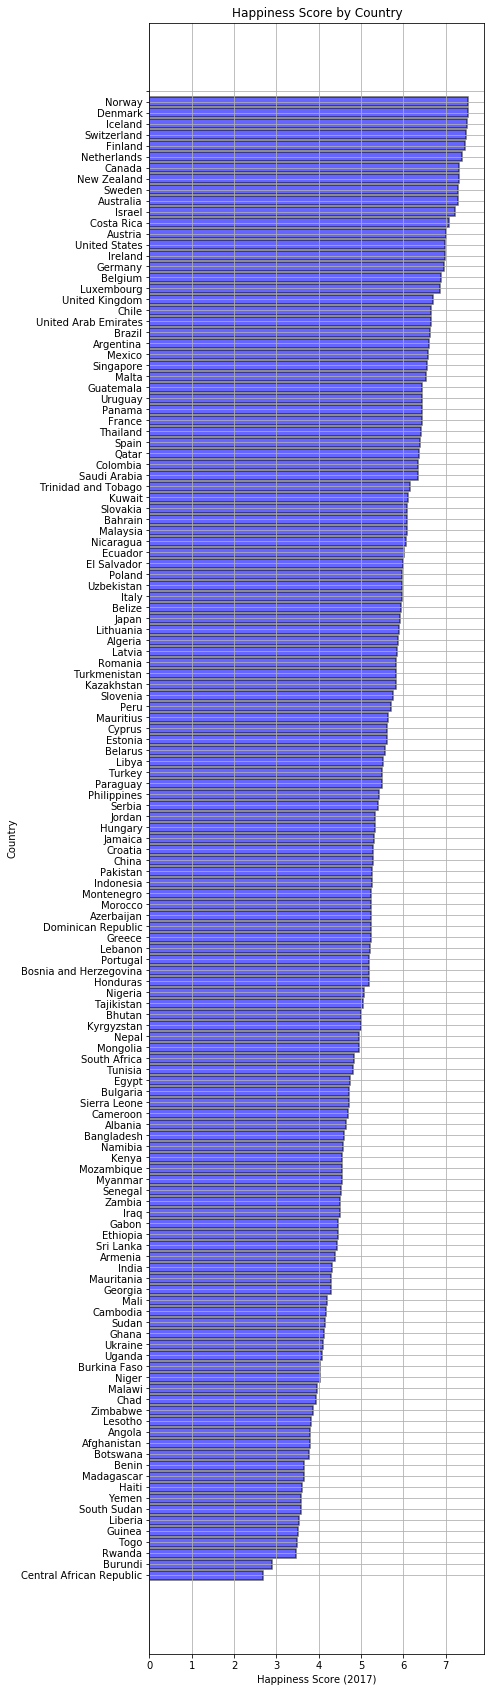

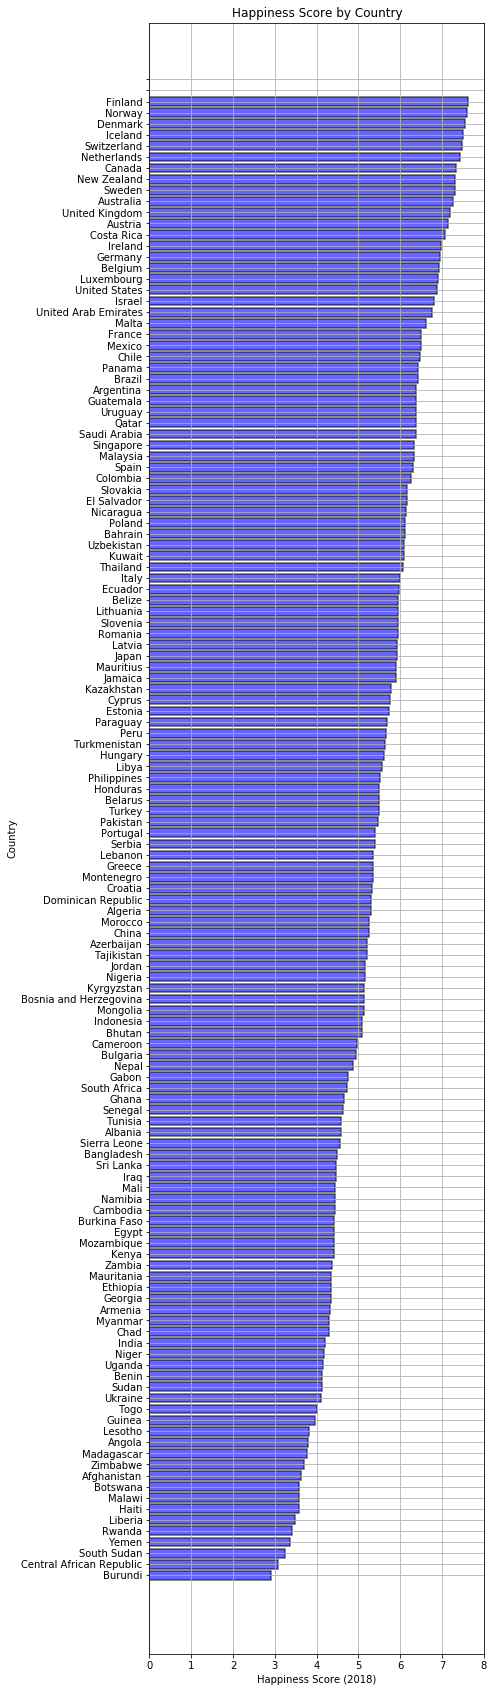

In [87]:
for year in years:
    happiness_year_df = combined_df.loc[(combined_df['year']==year)][['country','happiness_score']]
    happiness_year_df = happiness_year_df.sort_values('happiness_score',ascending=False).reset_index(drop=True)
    x_axis = list(range(0,136,1))
    tick_locations = x_axis
    y_ticks = happiness_year_df['country'][::-1]
    x_values = happiness_year_df['happiness_score'][::-1]
    fig, ax = plt.subplots(figsize=(6,30))
    ax.barh(y_ticks, x_values, color="b", alpha=0.6, linewidth=1.5, edgecolor='black')
    ax.set_yticks(x_axis)
    ax.set_xlabel(f"Happiness Score ({year})")
    ax.set_ylabel("Country")
    ax.set_title("Happiness Score by Country")
    ax.grid()

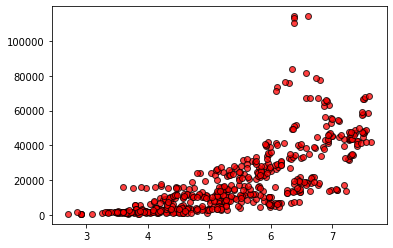

In [88]:
plt.scatter(combined_df['happiness_score'],combined_df['gni_per_capita'], marker="o", facecolors="red", edgecolors="black",alpha=0.75)
